# MNIST Intro

In [2]:
from datasets import load_dataset
from torchvision.utils import make_grid
from torchvision import transforms

In [14]:
ds = load_dataset("zalando-datasets/fashion_mnist")

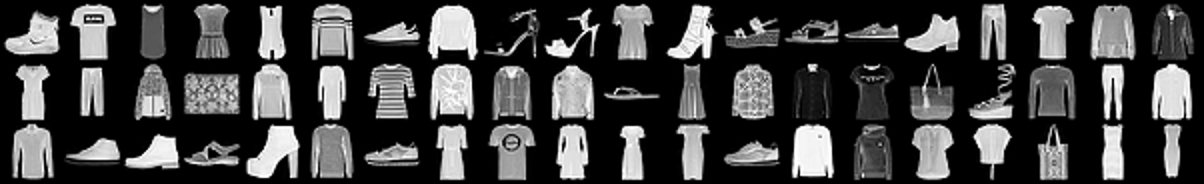

In [20]:
grid=make_grid([
    transforms.ToTensor()(i) 
    for i in ds["train"][:60]["image"]
], nrow=20)

grid=transforms.ToPILImage()(grid)

grid.resize((grid.width * 2, grid.height * 2))

# Latent dataset

In [5]:
import torch

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [6]:
from diffusers import AutoencoderDC

model_repo = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

dcae = AutoencoderDC.from_pretrained(
    model_repo, 
    subfolder="vae", 
    torch_dtype=dtype
).to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [7]:
from utils import latent_to_PIL, PIL_to_latent

In [8]:
img_orig = ds["train"][0]["image"]
img_orig

32px


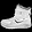

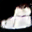

64px


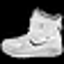

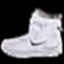

96px


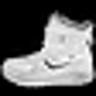

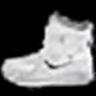

128px


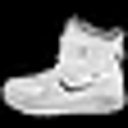

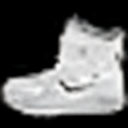

In [9]:
for dim in [32, 64, 96, 128]:
    print(f"{dim}px")
    img = img_orig.convert('RGB').resize((dim, dim))
    img = img
    display(img)
    display(
        latent_to_PIL(
            PIL_to_latent(img, dcae),
            dcae
        )
    )

In [22]:
ds = load_dataset("g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0")

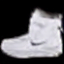

In [11]:
# inspect first sample
latent = torch.Tensor(ds["train"][0]["latent"])
latent_to_PIL(latent.to(dtype).to(device), dcae)

tensor([0.])


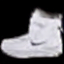

tensor([0.1000])


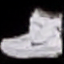

tensor([0.2500])


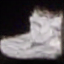

tensor([0.5000])


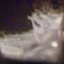

tensor([0.7500])


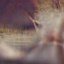

tensor([1.])


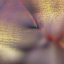

In [12]:
# gaussian noise
noise = torch.randn_like(latent)

# noise level, float between 0 and 1 
for sigma in [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]:
    sigma = torch.Tensor([sigma])

    # (1-sigma) * latent + sigma * noise
    latent_noisy = (1 - sigma) * latent * dcae.config["scaling_factor"] + sigma * noise

    print(sigma)
    display(
        latent_to_PIL(latent_noisy.to(dtype).to(device) / dcae.config["scaling_factor"], dcae)
    )


In [23]:
def add_random_noise(latents, timesteps=1000):
    # batch size
    bs = latents.size(0)

    # gaussian noise
    noise = torch.randn_like(latents)

    # normal distributed sigmas
    sigmas = torch.randn((bs,)).sigmoid().to(latents.device)
    
    timesteps = (sigmas * timesteps).to(latents.device)   # yes, `timesteps = sigmas * 1000`, let's keep it simple
    sigmas = sigmas.view([latents.size(0), *([1] * len(latents.shape[1:]))])
    
    latents_noisy = (1 - sigmas) * latents + sigmas * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy.to(latents.dtype), timesteps, noise

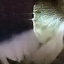

In [24]:
latent_noisy, timesteps, noise = add_random_noise(latent * dcae.config["scaling_factor"])

display(
    latent_to_PIL(latent_noisy.to(dtype).to(device) / dcae.config["scaling_factor"], dcae)
)


# Setting up the Diffusion Transformer

In [25]:
from diffusers import SanaTransformer2DModel

config = SanaTransformer2DModel.load_config(
    "Efficient-Large-Model/Sana_600M_1024px_diffusers",
    subfolder="transformer"
)

# ModernBERT embeddings dimension
config["caption_channels"] = 768

config["num_layers"] = 12
config["num_attention_heads"] = 6
config["attention_head_dim"] = 64

config["cross_attention_dim"] = 384
config["num_cross_attention_heads"] = 6

transformer = SanaTransformer2DModel.from_config(config)
transformer.to(dtype).to(device)

print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")

Transformer parameters: 30.22M


In [26]:
# Load the text encoder
from transformers import AutoModel, AutoTokenizer
from utils import encode_prompt

te_repo = "answerdotai/ModernBERT-base"

tokenizer = AutoTokenizer.from_pretrained(te_repo, torch_dtype=dtype)
text_encoder = AutoModel.from_pretrained(te_repo, torch_dtype=dtype).to(device)

## Calculate gradients from a single sample

In [27]:
# Load a sample
sample = ds["train"][0]

# Label, e.g. "5"
label = sample["label"]

# Encode the label 
prompt_encoded, prompt_atnmask = encode_prompt(
    str(label), 
    tokenizer, 
    text_encoder
)

# Get the preprocessed Latent
latent = torch.Tensor(sample["latent"]).to(dtype).to(device)

# Scale latent and a random amount of noise
latent = latent * dcae.config["scaling_factor"]
latents_noisy, timestep, noise = add_random_noise(latent)

# Get a noise prediction out of the model
noise_pred = transformer(
    hidden_states = latents_noisy.to(dtype), 
    encoder_hidden_states = prompt_encoded, 
    encoder_attention_mask = prompt_atnmask,
    timestep=timestep, 
).sample

noise_pred.shape

torch.Size([1, 32, 2, 2])

In [28]:
import torch.nn.functional as F

# mean squared error of prediction and target
loss = F.mse_loss(noise_pred, noise - latent)

# calculate gradients
loss.backward()
loss

tensor(2.7344, device='mps:0', dtype=torch.bfloat16,
       grad_fn=<MseLossBackward0>)

## Minimal training loop

In [29]:
from torch.utils.data import DataLoader

def collate(items):
    labels = [str(i["label"]) for i in items]
    prompts_emb, prompts_atnmask = encode_prompt(labels, tokenizer, text_encoder)

    latents = torch.cat(
        [torch.Tensor(i["latent"]) for i in items]
    ).to(dtype).to(device)

    return labels, prompts_emb, prompts_atnmask, latents

dataloader = DataLoader(
    ds["train"], 
    batch_size=128,
    collate_fn=collate
)

labels, prompts_emb, prompts_atnmask, latents = next(iter(dataloader))
latents.shape, prompts_emb.shape

(torch.Size([128, 32, 2, 2]), torch.Size([128, 50, 768]))

In [30]:
optimizer = torch.optim.AdamW(transformer.parameters(), lr = 1e-3)

In [31]:
from utils import generate
from functools import partial

# fix generate with pipeline components
generate = partial(
    generate, 
    transformer=transformer, 
    tokenizer=tokenizer, 
    text_encoder=text_encoder,
    dcae=dcae
)

49 2.015625


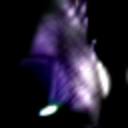

In [ ]:
# train for 500 steps

for step, (labels, prompts_emb, prompts_atnmask, latents) in enumerate(dataloader):
    # Scale latent and a random amount of noise
    latents = latents * dcae.config["scaling_factor"]
    latents_noisy, timestep, noise = add_random_noise(latents)
    
    # Get a noise prediction out of the model
    noise_pred = transformer(
        hidden_states = latents_noisy.to(dtype), 
        encoder_hidden_states = prompts_emb, 
        encoder_attention_mask = prompts_atnmask,
        timestep=timestep, 
    ).sample

    optimizer.zero_grad()
    
    loss = F.mse_loss(noise_pred, noise - latents)
    loss.backward()

    optimizer.step()

    if (step + 1) % 50 == 0:
        print(step, loss.item())
        display(
            generate(
                "0",
                latent_dim = [1, 32, 2, 2],
                num_steps = 10,
            ).resize((128, 128))
        )
    if (step + 1) % 300 == 0:
        break

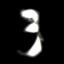

In [37]:
generate("3", latent_dim=[1, 32, 2, 2])